# OpenEarhMap Semantinc Segmentation

original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

---

### Requirements

In [1]:
!pip install git+https://github.com/bao18/open_earth_map

  Cloning https://github.com/bao18/open_earth_map to /tmp/pip-req-build-_87sk00f
  Running command git clone --filter=blob:none --quiet https://github.com/bao18/open_earth_map /tmp/pip-req-build-_87sk00f
  Resolved https://github.com/bao18/open_earth_map to commit f16da336f8abf549e94a206ef67ab869654a557e
  Preparing metadata (setup.py) ... done


In [2]:
import os
# import gdown
# import zipfile

# url = "https://drive.google.com/uc?export=download&confirm=pbef&id=1SqLqv1RCJdiUFnnfIce78M9nJF_KF11U"
# output = "OpenEathMap_Mini.zip"
# gdown.download(url, output, quiet=False)

# with zipfile.ZipFile(output, 'r') as fzip:
#     fzip.extractall()
# os.remove(output)

### Imports
---

In [3]:
import time
import warnings
import numpy as np
import torch
import rasterio
import cv2
import open_earth_map as oem
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Defines main parameters

In [4]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/workspace/hdd0/byeongcheol/Remote_Sensing/OpenEarthMap_wo_xBD/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 4
NUM_EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

### Prepares training and validation file lists.

In [5]:
fns = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in fns if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in fns if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(fns))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 3838
Training samples   : 2303
Validation samples : 384


### Prepares training and validation augmentations.

In [6]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

### Defines training and validation dataloaders

In [7]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

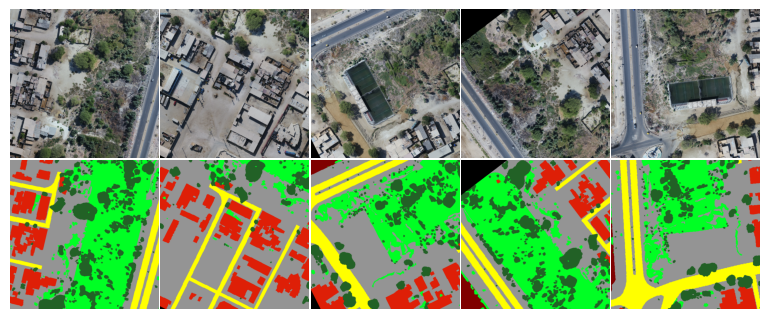

In [8]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 1
for i in range(5):
    
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

In [9]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)

val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

### Defines the network architecture, optimizer, and criterion

In [10]:
from open_earth_map.losses import JointLoss

# network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.networks.UNetFormer(n_classes=N_CLASSES)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
# criterion = oem.losses.JaccardLoss()
criterion = JointLoss(oem.losses.SoftCrossEntropyLoss(smooth_factor=0.05), oem.losses.DiceLoss(class_weights=0.05))

### Trains and validates the network

In [11]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")
    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.23it/s, Loss=7.35, Score=0.169]


model saved

Epoch: 2


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.13it/s, Loss=7.04, Score=0.206]


model saved

Epoch: 3


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.11it/s, Loss=7.49, Score=0.171]



Epoch: 4


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.19it/s, Loss=6.94, Score=0.219]


model saved

Epoch: 5


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.12it/s, Loss=6.78, Score=0.236]


model saved

Epoch: 6


Valid: 100%|██████████| 96/96 [00:08<00:00, 11.89it/s, Loss=6.77, Score=0.241]


model saved

Epoch: 7


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.08it/s, Loss=6.73, Score=0.241]



Epoch: 8


Valid: 100%|██████████| 96/96 [00:08<00:00, 11.64it/s, Loss=6.8, Score=0.233] 



Epoch: 9


Valid: 100%|██████████| 96/96 [00:08<00:00, 11.69it/s, Loss=6.71, Score=0.241]


model saved

Epoch: 10


Valid: 100%|██████████| 96/96 [00:07<00:00, 12.33it/s, Loss=6.68, Score=0.25] 


model saved
Elapsed time: 11.498 min


# Testing 

### Prepares testing files

In [21]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")
PREDS_DIR = "predictions"
os.makedirs(PREDS_DIR, exist_ok=True)

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 3838
Testing samples : 1151


### Defines test dataloader

In [22]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

### Loads trained network

In [23]:
# network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
network = oem.networks.UNetFormer(n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="model.pth", model_dir="outputs")

Loaded model:model.pth (Epoch=9, Score=0.250)


### Makes predictions

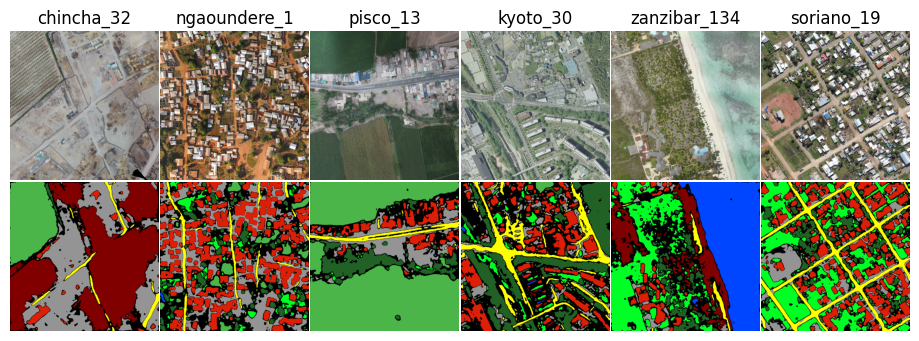

In [24]:
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, fn = test_data[idx][0], test_data[idx][2]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    fout = os.path.join(PREDS_DIR, fn.split("/")[-1])
    with rasterio.open(fn, "r") as src:
        profile = src.profile
        prd = cv2.resize(
            prd,
            (profile["width"], profile["height"]),
            interpolation=cv2.INTER_NEAREST,
        )
        with rasterio.open(fout, "w", **profile) as dst:
            for idx in src.indexes:
                dst.write(prd[:, :, idx - 1], idx)

    img = np.moveaxis(img.numpy(), 0, -1)
    axs[0, i].imshow(img)
    axs[0, i].set_title(fn.split("/")[-1][:-4])    
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

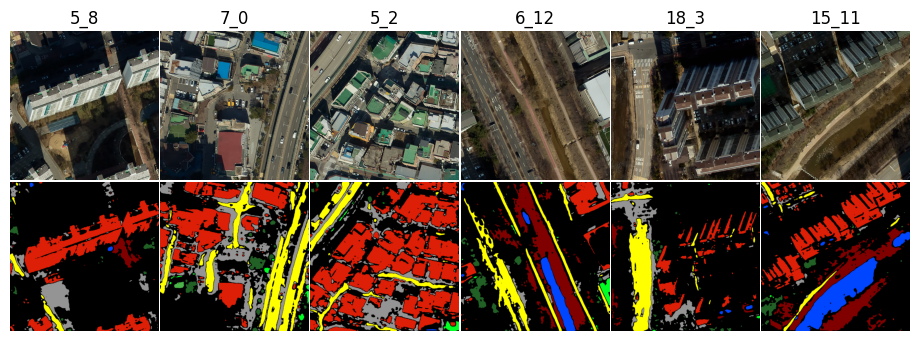

In [25]:
NPLOT = 6

skku_tile="/workspace/hdd0/byeongcheol/Remote_Sensing/skku_tiles"
skku_tile_list = os.listdir(skku_tile)
skku_tile_list = [os.path.join(skku_tile, f) for f in skku_tile_list]
test_data = oem.dataset.OpenEarthMapDataset(skku_tile_list, n_classes=N_CLASSES, augm=None, testing=True)
idxs = np.argsort(np.random.rand(len(skku_tile_list)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)


network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, fn = test_data[idx][0], test_data[idx][2]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    fout = os.path.join(PREDS_DIR, fn.split("/")[-1])
    with rasterio.open(fn, "r") as src:
        profile = src.profile
        prd = cv2.resize(
            prd,
            (profile["width"], profile["height"]),
            interpolation=cv2.INTER_NEAREST,
        )
        with rasterio.open(fout, "w", **profile) as dst:
            for idx in src.indexes:
                dst.write(prd[:, :, idx - 1], idx)

    img = np.moveaxis(img.numpy(), 0, -1)
    axs[0, i].imshow(img)
    axs[0, i].set_title(fn.split("/")[-1][:-4])    
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

In [30]:
# Test All
from tqdm import tqdm
skku_tile="/workspace/hdd0/byeongcheol/Remote_Sensing/skku_tiles"
skku_tile_list = os.listdir(skku_tile)
skku_tile_list = [os.path.join(skku_tile, f) for f in skku_tile_list if f.endswith(".png")]
test_data = oem.dataset.OpenEarthMapDataset(skku_tile_list, n_classes=N_CLASSES, augm=None, testing=True)


OUTPUT_DIR="skku_tiles"
os.makedirs(OUTPUT_DIR, exist_ok=True)

network.eval().to(DEVICE)
for idx, filename in tqdm(enumerate(range(len(test_data))), total=len(test_data)):
    img, fn = test_data[idx][0], test_data[idx][2]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    fout = os.path.join(OUTPUT_DIR, fn.split("/")[-1])
    with rasterio.open(fn, "r") as src:
        profile = src.profile
        prd = cv2.resize(
            prd,
            (profile["width"], profile["height"]),
            interpolation=cv2.INTER_NEAREST,
        )
        with rasterio.open(fout, "w", **profile) as dst:
            for idx in src.indexes:
                dst.write(prd[:, :, idx - 1], idx)

    

100%|██████████| 266/266 [02:58<00:00,  1.49it/s]


: 